In [90]:
import pandas as pd
import matplotlib.colors as mcolors
from operator import attrgetter
import seaborn as sns

In [91]:
df = pd.read_csv("dataset.csv", 
                 header = 0, 
                 sep = ';',
                 usecols = ["CLIENT_ID", "VALUE_DAY"],
                 parse_dates = [1],)
df

C:\Users\polia\AppData\Local\Temp\ipykernel_11076\1576903203.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv("dataset.csv",


,CLIENT_ID,VALUE_DAY
0,3596869440,2021-09-30
1,181778433,2021-09-30
2,4271531990,2021-09-30
3,3949165697,2021-09-30
4,1926920317,2021-09-30
...,...,...
805816,4243322997,2022-02-28
805817,67461867,2022-02-28
805818,302417315,2022-02-28
805819,1780553365,2022-02-28


In [92]:
# Создадим переменные cohort и order_month. 
# cohort указывает ежемесячную когорту на основе первой даты покупки, а order_month — усеченный месяц с даты авторизации
df['order_month'] = df['VALUE_DAY'].dt.to_period('M')

In [93]:
df['cohort'] = df.groupby('CLIENT_ID')['VALUE_DAY'].transform('min').dt.to_period('M')

In [94]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('CLIENT_ID', 'nunique')).reset_index(drop=False)

In [95]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [96]:
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2021-09,2021-09,129232,0
1,2021-09,2021-10,124593,1
2,2021-09,2021-11,120232,2
3,2021-09,2021-12,116456,3
4,2021-09,2022-01,105547,4


In [97]:
# Aгрегируем данные по когорте и order_month и подсчитываем количество уникальных клиентов в каждой группе.
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

In [98]:
cohort_pivot

period_number,0,1,2,3,4,5
cohort,,,,,,
2021-09,129232.0,124593.0,120232.0,116456.0,105547.0,104163.0
2021-10,7044.0,6936.0,6883.0,5040.0,4800.0,NaN
2021-11,5841.0,5743.0,5225.0,4377.0,NaN,NaN
2021-12,6875.0,6188.0,6170.0,NaN,NaN,NaN
2022-01,14770.0,14374.0,NaN,NaN,NaN,NaN
2022-02,5330.0,NaN,NaN,NaN,NaN,NaN


In [99]:
cohort_size = cohort_pivot.iloc[:, 0]

In [100]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

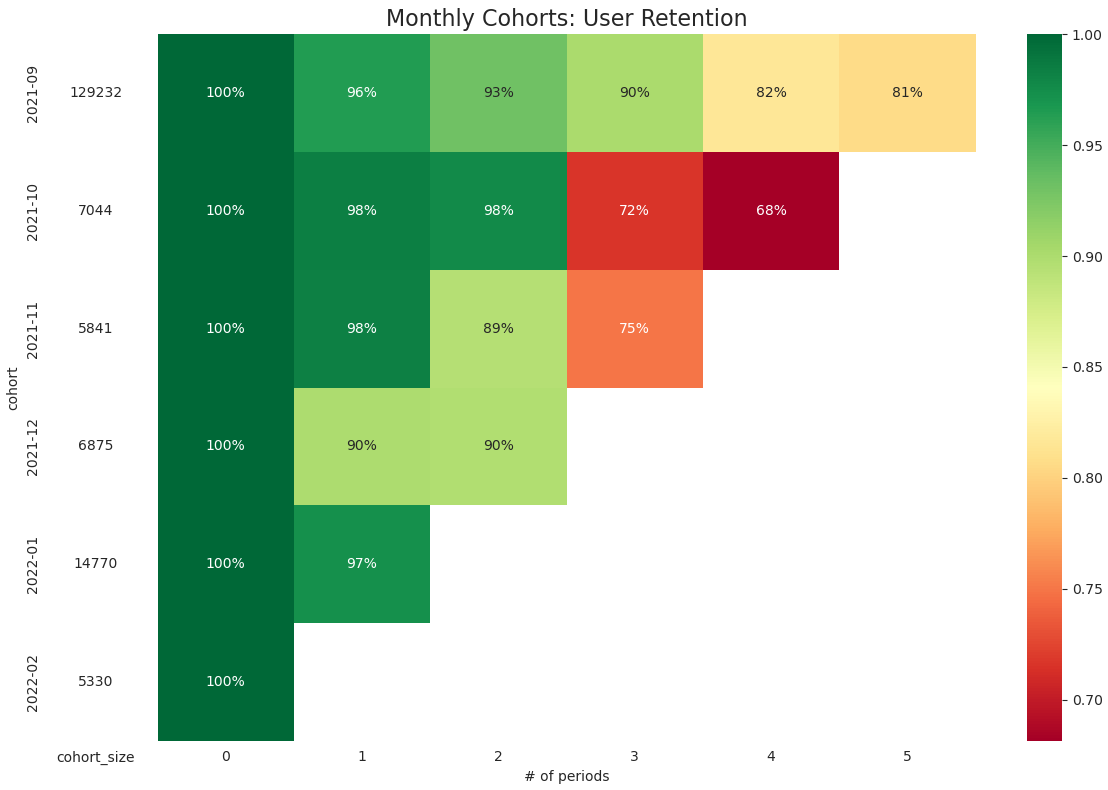

In [101]:
# Строим матрицу удержания в виде тепловой карты. 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()